<a href="https://colab.research.google.com/github/simply-sankalp/GHI-forecast/blob/main/normalityTest_bestfitDist2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 2000.csv to 2000.csv
Saving 2001.csv to 2001.csv
Saving 2002.csv to 2002.csv
Saving 2003.csv to 2003.csv
Saving 2004.csv to 2004.csv
Saving 2005.csv to 2005.csv
Saving 2006.csv to 2006.csv
Saving 2007.csv to 2007.csv
Saving 2008.csv to 2008.csv
Saving 2009.csv to 2009.csv
Saving 2010.csv to 2010.csv
Saving 2011.csv to 2011.csv
Saving 2012.csv to 2012.csv
Saving 2013.csv to 2013.csv
Saving 2014.csv to 2014.csv


/tmp/ipython-input-2437759564.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ghi = ghi.fillna(method='ffill').fillna(method='bfill')


Total cleaned GHI values: 58728


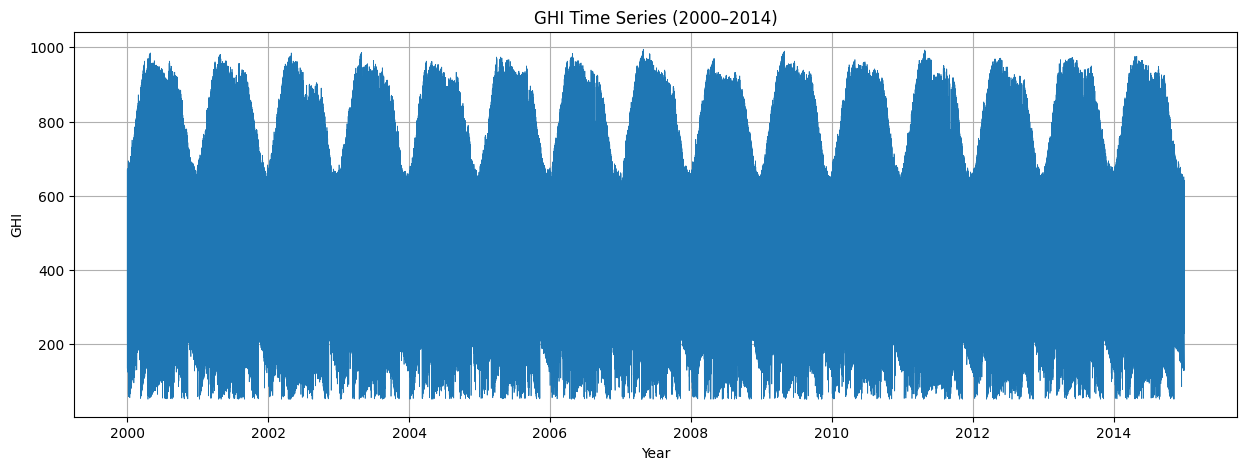


===== ANDERSON–DARLING NORMALITY TEST =====
Statistic: 699.4068

Critical Values:
Significance Level: 15.0% | Critical Value: 0.576
Significance Level: 10.0% | Critical Value: 0.656
Significance Level: 5.0% | Critical Value: 0.787
Significance Level: 2.5% | Critical Value: 0.918
Significance Level: 1.0% | Critical Value: 1.092

Conclusion at 5% level:
As test Statistic (699.4068) > critcal value (0.787)
Reject H0 → Data is NOT Normally Distributed

===== Z-PROPORTION NORMALITY TEST =====
P(|X-μ| < 1σ): observed=0.5811, Z=-52.918
P(|X-μ| < 2σ): observed=1.0000, Z=52.910
P(|X-μ| < 3σ): observed=1.0000, Z=12.609
As z-value > 1.96
RESULT: Reject H0 → Data is NOT Normally Distributed

===== DISTRIBUTION FIT (AIC SCORES) =====
Lognormal AIC: 838022.60
Gamma AIC:     826437.14
Weibull AIC:   819560.84
BEST FIT: WEIBULL Distribution

===== FINAL CONCLUSION =====
Anderson–Darling Test: NOT Normal
Z-proportion test: NOT Normal

Conclusion: GHI DOES NOT FOLLOW NORMAL DISTRIBUTION.
Best-fitting d

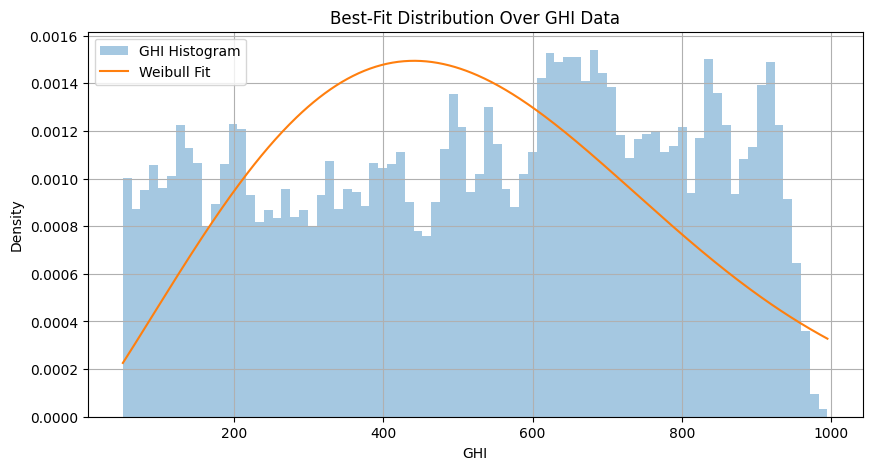

In [13]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import anderson, lognorm, gamma, weibull_min, skew
from math import sqrt

# ---------------------------------------------------------
# 1. LOAD & MERGE ALL CSV FILES
# ---------------------------------------------------------
file_list = sorted(uploaded.keys())
dfs = []
for f in uploaded.keys():
    df = pd.read_csv(f, skiprows=2)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# ---------------------------------------------------------
# 2. CREATE DATETIME INDEX
# ---------------------------------------------------------
data['Datetime'] = pd.to_datetime(
    data[['Year', 'Month', 'Day', 'Hour', 'Minute']],
    errors='coerce'
)
data = data.dropna(subset=['Datetime'])
data = data.set_index('Datetime')

# ---------------------------------------------------------
# 3. CLEAN GHI COLUMN
# ---------------------------------------------------------
ghi = pd.to_numeric(data['GHI'], errors='coerce')
ghi = ghi.fillna(method='ffill').fillna(method='bfill')

# Remove night-time zeroes (improves distribution tests)
ghi = ghi[ghi > 50]

print("Total cleaned GHI values:", len(ghi))

plt.figure(figsize=(15,5))
plt.plot(ghi.index, ghi.values, linewidth=0.5)
plt.title("GHI Time Series (2000–2014)")
plt.xlabel("Year")
plt.ylabel("GHI")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 4. PRIMARY NORMALITY TEST:
# ---------------------------------------------------------
print("\n===== ANDERSON–DARLING NORMALITY TEST =====")

ad_result = anderson(ghi, dist='norm')

print(f"Statistic: {ad_result.statistic:.4f}")
print("\nCritical Values:")
for sl, cv in zip(ad_result.significance_level, ad_result.critical_values):
    print(f"Significance Level: {sl:>3}% | Critical Value: {cv}")

# Use 5% significance level → index = 2
cv_5 = ad_result.critical_values[2]

print("\nConclusion at 5% level:")
if ad_result.statistic > cv_5:
    print(f"As test Statistic ({ad_result.statistic:.4f}) > critcal value ({cv_5})")
    print("Reject H0 → Data is NOT Normally Distributed")
else:
    print(f"As test Statistic ({ad_result.statistic}) < critcal value ({cv_5})")
    print("Fail to Reject H0 → Data MAY be Normal")

# ---------------------------------------------------------
# 5. Z-PROPORTION TEST (±1σ, ±2σ, ±3σ)
# ---------------------------------------------------------
mu = ghi.mean()
sigma = ghi.std()
n = len(ghi)

p1 = ((ghi > mu - sigma) & (ghi < mu + sigma)).mean()
p2 = ((ghi > mu - 2*sigma) & (ghi < mu + 2*sigma)).mean()
p3 = ((ghi > mu - 3*sigma) & (ghi < mu + 3*sigma)).mean()

def ztest(phat, p0, n):
    return (phat - p0) / sqrt(p0*(1-p0)/n)

z1 = ztest(p1, 0.6827, n)
z2 = ztest(p2, 0.9545, n)
z3 = ztest(p3, 0.9973, n)

print("\n===== Z-PROPORTION NORMALITY TEST =====")
print(f"P(|X-μ| < 1σ): observed={p1:.4f}, Z={z1:.3f}")
print(f"P(|X-μ| < 2σ): observed={p2:.4f}, Z={z2:.3f}")
print(f"P(|X-μ| < 3σ): observed={p3:.4f}, Z={z3:.3f}")

# Interpretation
if abs(z1) > 1.96 or abs(z2) > 1.96 or abs(z3) > 1.96:
    print("As z-value > 1.96")
    print("RESULT: Reject H0 → Data is NOT Normally Distributed")
else:
    print("RESULT: Fail to Reject H0 → Data MAY be Normal")

# ---------------------------------------------------------
# 6. BEST-FIT DISTRIBUTION: LOGNORMAL, GAMMA, WEIBULL
# ---------------------------------------------------------
# Lognormal
shape_ln, loc_ln, scale_ln = lognorm.fit(ghi, floc=0)
aic_ln = 2*2 - 2*np.sum(lognorm.logpdf(ghi, shape_ln, loc=loc_ln, scale=scale_ln))

# Gamma
shape_gm, loc_gm, scale_gm = gamma.fit(ghi, floc=0)
aic_gm = 2*2 - 2*np.sum(gamma.logpdf(ghi, shape_gm, loc=loc_gm, scale=scale_gm))

# Weibull
shape_wb, loc_wb, scale_wb = weibull_min.fit(ghi, floc=0)
aic_wb = 2*2 - 2*np.sum(weibull_min.logpdf(ghi, shape_wb, loc=loc_wb, scale=scale_wb))

best = min(aic_ln, aic_gm, aic_wb)

print("\n===== DISTRIBUTION FIT (AIC SCORES) =====")
print(f"Lognormal AIC: {aic_ln:.2f}")
print(f"Gamma AIC:     {aic_gm:.2f}")
print(f"Weibull AIC:   {aic_wb:.2f}")

best = min(aic_ln, aic_gm, aic_wb)
if best == aic_ln:
    print("BEST FIT: LOGNORMAL Distribution")
elif best == aic_gm:
    print("BEST FIT: GAMMA Distribution")
else:
    print("BEST FIT: WEIBULL Distribution")

# ---------------------------------------------------------
# 7. FINAL SUMMARY
# ---------------------------------------------------------
print("\n===== FINAL CONCLUSION =====")
ad_5_crit = ad_result.critical_values[2]
print("Anderson–Darling Test:", "NOT Normal" if ad_result.statistic > ad_5_crit else "Possibly Normal")
print("Z-proportion test:", "NOT Normal" if abs(z1)>1.96 or abs(z2)>1.96 or abs(z3)>1.96 else "Possibly Normal")

print("\nConclusion: GHI DOES NOT FOLLOW NORMAL DISTRIBUTION.")
print("Best-fitting distribution:",
      "Lognormal" if best==aic_ln else ("Gamma" if best==aic_gm else "Weibull"))

x = np.linspace(ghi.min(), ghi.max(), 500)

plt.figure(figsize=(10,5))
plt.hist(ghi, bins=80, density=True, alpha=0.4, label="GHI Histogram")

if best == aic_ln:
    plt.plot(x, lognorm.pdf(x, shape_ln, loc_ln, scale_ln), label="Lognormal Fit")
elif best == aic_gm:
    plt.plot(x, gamma.pdf(x, shape_gm, loc_gm, scale_gm), label="Gamma Fit")
else:
    plt.plot(x, weibull_min.pdf(x, shape_wb, loc_wb, scale_wb), label="Weibull Fit")

plt.title("Best-Fit Distribution Over GHI Data")
plt.xlabel("GHI")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()